# Pitch Deck Dataset Data Cleaning

## Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from gensim.models import Word2Vec
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


from wordcloud import WordCloud

import ast #convert strings to lists
from geopy.geocoders import Nominatim # get geolocation data for mapping
import folium #interactive map

## Import Dataset

In [2]:
df = pd.read_csv('data/falory.csv')

In [3]:
df.head()

,Name,Description,Industry,Business Model,Customer,Round,AmountRaised,Investor,Year,Links,Location
0,Airbnb,Airbnb is an online marketplace for people to ...,"Hospitality, Travel",Marketplace,"B2C, B2B",Seed,$600K,"VC, Angel Investors",2008,"['https://airbnb.com/', 'https://www.crunchbas...","['San Francisco', 'California', 'United States']"
1,Alan,Alan is a platform that uses technology to mak...,"FinTech, Healthcare, InsurTech",App,B2B,Series C,$54M,VC,2020,"['https://alan.com/', 'https://www.crunchbase....","['Paris', 'Ile-de-France', 'France']"
2,Apptopia,Apptopia serves the mobile industry with an ar...,"Analytics, Big Data, Marketing",Subscription,B2B,Series A,$1.46M,VC,2018,"['http://www.apptopia.com/', 'https://www.crun...","['Boston', 'Massachusetts', 'United States']"
3,Beatdapp,Beatdapp provides real-time tracking of media ...,"Blockchain, Software, Music, Audio, Analytics",SaaS,B2B,Seed,$2.4M,VC,2019,"['https://beatdapp.com/', 'https://www.crunchb...","['Vancouver', 'British Columbia', 'Canada']"
4,Bind,"Bind provides personalized, cost-transparent a...","InsurTech, Healthcare, HR",Subscription,"B2C, B2B",Series A,$60M,VC,2018,"['https://www.yourbind.com/', 'https://www.cru...","['Minneapolis', 'Minnesota', 'United States']"


## Startups Sectors & Industries

In [38]:
def get_industry_similarities(df):
    """This will tell us how our dataset is distributed and if it is unbalanced. 
    It returns how much each word is similar to the other."""
    #how many industries are there in this dataset? 437!
    industry_count = df['Industry'].value_counts()
    #print(str(len(industry_count)) + " industries")
    #print(industry_count)

    #Are industry labels similar, do we need 437?
    #preprocess industry text
    industries = df['Industry'].str.lower().str.replace('[^\w\s]', '').str.split(', ').apply(
        lambda x: [word.strip() for phrase in x for word in phrase.split()]) #lower then split by comma and white space

    industries = industries.apply(lambda x: list(set(x)))  # Use set to remove duplicates

    #print(str(len(industries)) + " industry labels") #Actually 495 labels!!
    #print(industries)

    #encode using Word2Vec
    model = Word2Vec(industries, vector_size=100, window=5, min_count=1, sg=0)

    #get vectors for each label
    industry_vectors = [model.wv[label].mean(axis=0) for label in industries] #remove nested lists within industries


    #get how much each word is similar to the other
    sims = cosine_similarity(industry_vectors, industry_vectors)
    return sims

def show_kmeans_elbow_graph(sims):
    """Plots the inertia values to determine the elbow point"""
    inertia = []#we will hold square distances for the difference
    k_values = range(1, 30)  # #We need a number of labels that define this dataset not 495 labels!!

    #we do kmeans for each k value and plot elbow
    for k in k_values:
        kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
        kmeans.fit(sims)
        inertia.append(kmeans.inertia_)

    # Plot the inertia values to determine the elbow point
    plt.figure(figsize=(10, 5))
    plt.plot(k_values, inertia, marker='o', linestyle='-', color='b')
    plt.title('Elbow Method for Optimal K')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('Inertia')
    plt.xticks(k_values)
    plt.grid(True)
    plt.show()

def generate_sector_clusters(sims, k=6):
    """Uses k-means clustering machine learning to group labels that are similar."""
    num_clusters = k  # found using the elbow method. 6 or 7 is good
    kmeans = KMeans(n_clusters=num_clusters)
    clusters = kmeans.fit_predict(sims)
    #we want to see what clusters look like but Word2Vec is in higher dimensional space. We use principle component analysis to bring it down into 2d world
    pca = PCA(n_components=2)
    reduced_features = pca.fit_transform(sims)

    #now we can visualise
    # Create a scatterplot to visualize the clusters
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=clusters, cmap='rainbow', alpha=0.7)

    plt.title('Similarity Clusters')
    plt.xlabel('PCA Dimension 1')
    plt.ylabel('PCA Dimension 2')

    # Create a legend with cluster labels
    legend_labels = list(set(clusters))  # Get unique cluster labels
    handles = [plt.Line2D([0], [0], marker='o', color='w', label=f'Cluster {label}', markersize=10,
                        markerfacecolor=scatter.to_rgba(label)) for label in legend_labels]

    plt.legend(handles=handles, title='Clusters')
    plt.show()

    #represent labels in clusters
    representative_labels = []
    for cluster_id in range(num_clusters):
        labels_in_cluster = df['Industry'][clusters == cluster_id].explode().value_counts()
        representative_label = labels_in_cluster.index[0]
        representative_labels.append(representative_label)

    
    category_names = {}
    for k, label in enumerate(representative_labels):
        category_names[k] = label
        #print(str(k) + " " + label)
    print("k: " + str(len(representative_labels)))
    print(category_names)

    return clusters, category_names

def map_sectors_to_industries(labels, clusters):
    #map old labels to new label clusters
    label_mapping = dict(zip(df['Industry'], clusters))
    #print(label_mapping)

    # Create a dictionary to map old labels to new category names
    label_mapping = {old_label: labels[new_label] for old_label, new_label in zip(df['Industry'], clusters)}
    return label_mapping

In [26]:
similarities = get_industry_similarities(df)

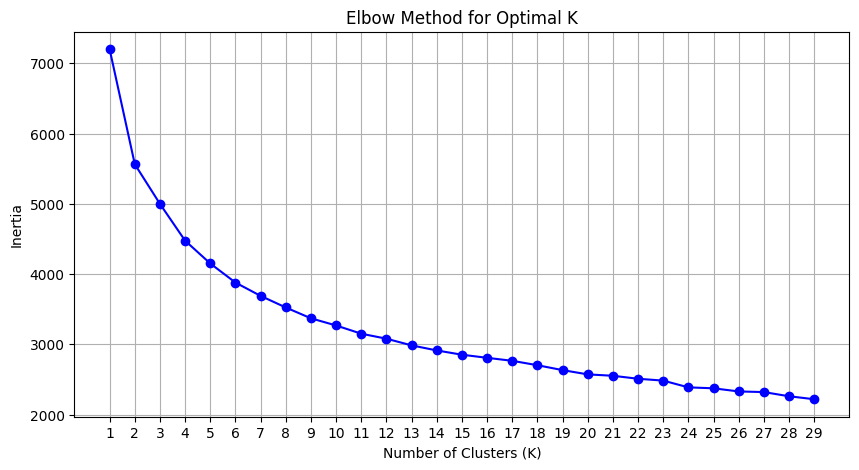

In [27]:
show_kmeans_elbow_graph(similarities)

it appears that the inertia values start to level off around K = 6 or 7

d:\Projects\repos\pitchedit\venv_pitchedit\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


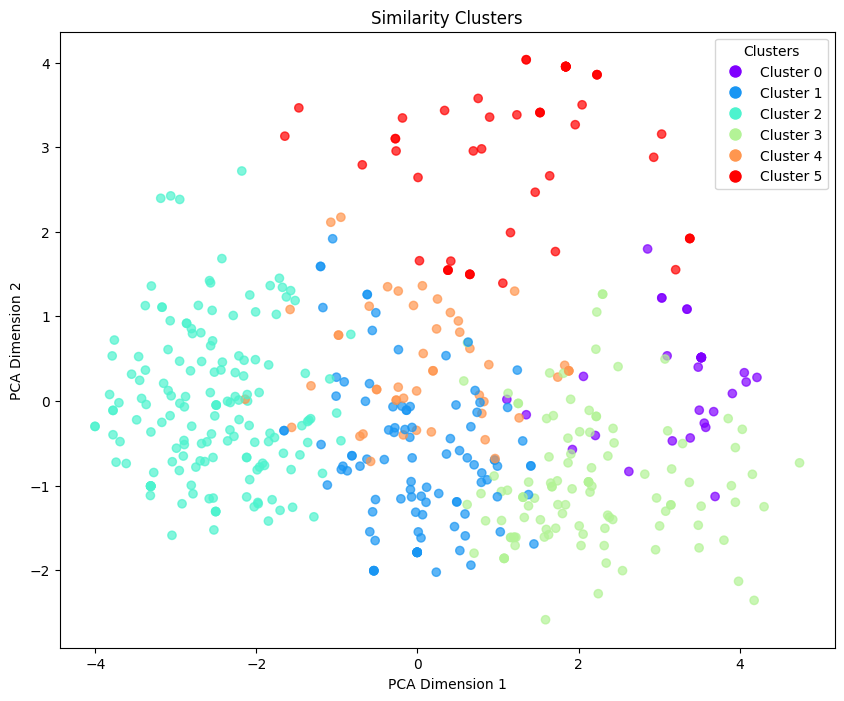

k: 6
{0: 'Retail, Fashion', 1: 'Healthcare', 2: 'Software, SaaS', 3: 'SaaS', 4: 'Analytics, Big Data', 5: 'FinTech, Payments'}


In [48]:
kmclusters, cluster_labels = generate_sector_clusters(sims=similarities, k=6)
# Define the category names
"""
cluster_labels = {
asked chatgpt to provide names for these clusters:
    0: 'Technology and Software',
    1: 'Healthcare and Biotechnology',
    2: 'Retail and Consumer',
    3: 'Entertainment and Social Media',
    4: 'Data and Analytics', 
    5: 'Financial Services', 
}
"""

label_mapping = map_sectors_to_industries(cluster_labels, kmclusters)

In [49]:
# Add a new column "Sector" based on the mapping
df['Sector'] = df['Industry'].map(label_mapping)

# Print the first few rows of the DataFrame to verify the new column
df.head()

,Name,Description,Industry,Business Model,Customer,Round,AmountRaised,Investor,Year,Links,Location,Sector
0,Airbnb,Airbnb is an online marketplace for people to ...,"Hospitality, Travel",Marketplace,"B2C, B2B",Seed,$600K,"VC, Angel Investors",2008,"['https://airbnb.com/', 'https://www.crunchbas...","['San Francisco', 'California', 'United States']",SaaS
1,Alan,Alan is a platform that uses technology to mak...,"FinTech, Healthcare, InsurTech",App,B2B,Series C,$54M,VC,2020,"['https://alan.com/', 'https://www.crunchbase....","['Paris', 'Ile-de-France', 'France']","FinTech, Payments"
2,Apptopia,Apptopia serves the mobile industry with an ar...,"Analytics, Big Data, Marketing",Subscription,B2B,Series A,$1.46M,VC,2018,"['http://www.apptopia.com/', 'https://www.crun...","['Boston', 'Massachusetts', 'United States']","Analytics, Big Data"
3,Beatdapp,Beatdapp provides real-time tracking of media ...,"Blockchain, Software, Music, Audio, Analytics",SaaS,B2B,Seed,$2.4M,VC,2019,"['https://beatdapp.com/', 'https://www.crunchb...","['Vancouver', 'British Columbia', 'Canada']","Software, SaaS"
4,Bind,"Bind provides personalized, cost-transparent a...","InsurTech, Healthcare, HR",Subscription,"B2C, B2B",Series A,$60M,VC,2018,"['https://www.yourbind.com/', 'https://www.cru...","['Minneapolis', 'Minnesota', 'United States']",Healthcare


In [50]:
df[df['Sector']=="SaaS"].head()

,Name,Description,Industry,Business Model,Customer,Round,AmountRaised,Investor,Year,Links,Location,Sector
0,Airbnb,Airbnb is an online marketplace for people to ...,"Hospitality, Travel",Marketplace,"B2C, B2B",Seed,$600K,"VC, Angel Investors",2008,"['https://airbnb.com/', 'https://www.crunchbas...","['San Francisco', 'California', 'United States']",SaaS
6,Blue Wire,Blue Wire is a network of podcasters who cover...,"Audio, Media, Entertainment, Sports",Other,B2C,Pre-Seed,$1.2M,VC,2020,"['https://bluewirepods.com/', 'https://www.cru...","['San Francisco', 'California', 'United States']",SaaS
7,Blue Apron,Blue Apron is a leading online marketplace for...,"Food, Logistics",Subscription,B2C,Series D,$135M,Corporate,2015,"['https://www.blueapron.com/', 'https://www.cr...","['New York', 'New York', 'United States']",SaaS
11,Buzzfeed,BuzzFeed is an internet media company deliveri...,"Media, Entertainment",Other,B2C,Series A,$3.5M,"VC, Angel Investors, Corporate",2008,"['https://www.buzzfeed.com/', 'https://www.cru...","['New York', 'New York', 'United States']",SaaS
21,Fyre Festival,Fyre Festival was a failed musical festival or...,"Events, Entertainment",Other,B2C,Early Stage,$25M,Angel Investors,2017,"['#', 'https://www.crunchbase.com/organization...","['New York', 'New York', 'United States']",SaaS


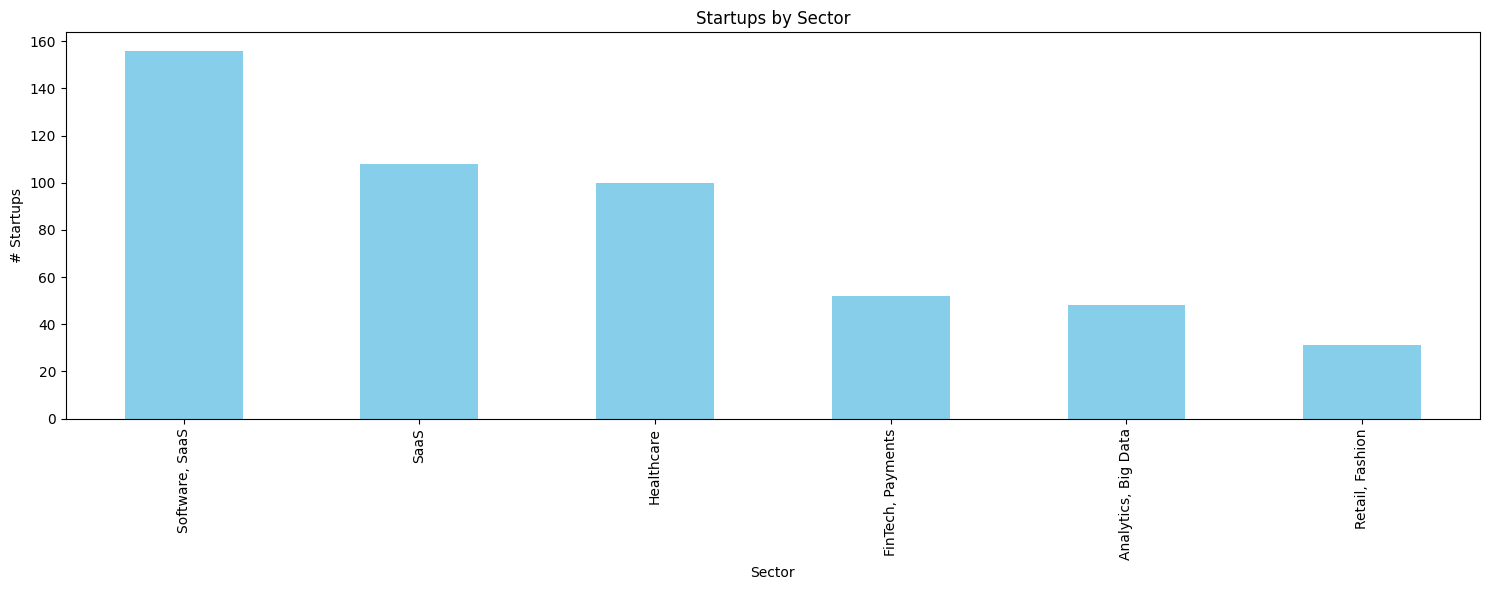

In [51]:
sector_counts = df['Sector'].value_counts()

# Create a bar chart
plt.figure(figsize=(15, 6))
sector_counts.plot(kind='bar', color='skyblue')

# Set plot labels and title
plt.title('Startups by Sector')
plt.xlabel('Sector')
plt.ylabel('# Startups')

# Wrap x-axis labels for better readability
plt.xticks(rotation=90)  # Set rotation to 0 degrees

# Display the bar chart
plt.tight_layout()
plt.show()

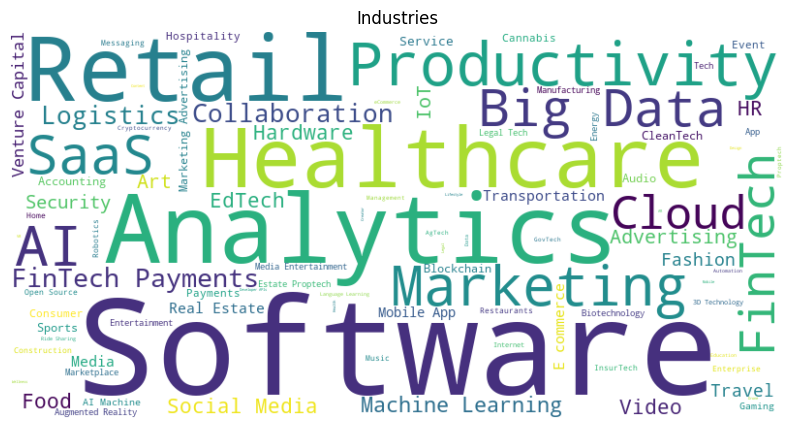

In [52]:
all_industries_text = ' '.join(df['Industry'])
# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_industries_text)
# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off axis labels
plt.title('Industries')
plt.show()


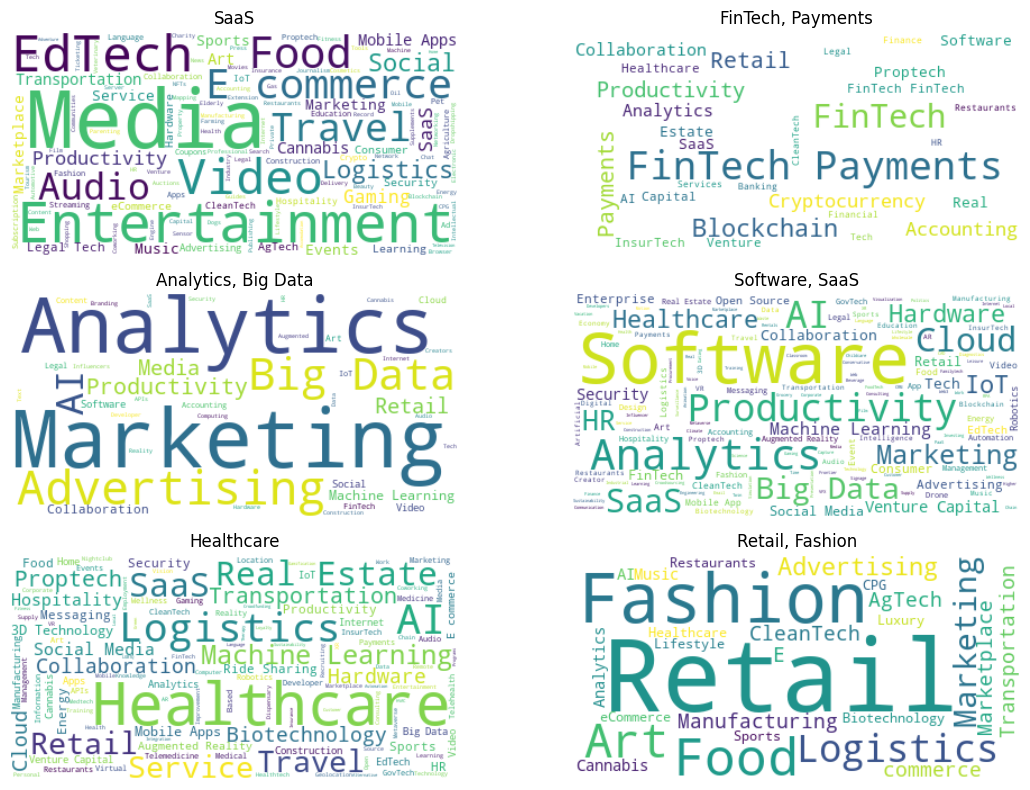

In [53]:
# Create a list of unique sectors in your DataFrame
unique_sectors = df['Sector'].unique()

# Set up subplots based on the number of unique sectors
num_rows = len(unique_sectors) // 2 + len(unique_sectors) % 2
num_cols = 2
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))
axes = axes.flatten()

# Iterate through unique sectors and create word clouds
for i, sector in enumerate(unique_sectors):
    # Concatenate all industries for the current sector into a single text string
    industries_text = ' '.join(df[df['Sector'] == sector]['Industry'])
    
    # Create a WordCloud object for the current sector
    wordcloud = WordCloud(width=400, height=200, background_color='white').generate(industries_text)
    
    # Plot the word cloud in the corresponding subplot
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].set_title(f'{sector}')
    axes[i].axis('off')

# Adjust subplot layout
plt.tight_layout()

# Show the word clouds
plt.show()

## Amount Raised by Startups
If we know the stage and the amount raised we could use this as a label to predict what funding a startup could get.

### handle currency symbols
We have several different currencies such as USD, CAD, GBP and EUR. We will need to convert them to one currency unit to normalise. We will first handle the symbols by converting them into text.

In [46]:
#values are in text format and contain currency and order of magnitude letters. Some symbles did not carry over correctly.
amount_raised_labels = df['AmountRaised'].unique()
print(amount_raised_labels)

['$600K' '$54M' '$1.46M' '$2.4M' '$60M' 'â\x82¬21M' '$1.2M' '$135M' '$57M'
 '$500K' '$102M' '$3.5M' '$70M' '$94M' '$5M' '$30M' '$13.8B' '$1.4M'
 '$10M' '$25M' 'â\x82¬2.5M' '$1M' '$100M' '$56M' '$43M' '$37M' '$50M'
 '$6.5M' '$65M' 'Â£19.3M' '$16M' '$2M' '$400K' '$66M' 'â\x82¬100M' '$68M'
 '$750K' '$6.8B' '$225M' '$200M' '$192M' '$28.5M' '$1.3M' '$200K' '$53M'
 '$335M' '$1.9M' '$19M' '$3.4M' '$632K' '$1.7M' '$18M' 'Undisclosed'
 '$2.2M' '$125K' '$9M' '$6M' '$5.3M' '$100K' '$299.6K' '$5.8M' '$2.5M'
 '$465K' '$725K' '$713K' '$15M' '$36M' '$650K' '$1.6M' '$760K' '$150K'
 'CA$1M' '$255K' '$800K' '$16.7M' '$4M' '$2.1M' '$460K' '$425K' '$300K'
 '$515K' '$12.5M' '$3M' '$120K' '$17M' '$10.3M' '$1.1M' '$1.5M' '$16.5M'
 '$20M' '$13M' '$7M' '$35M' '$1.12M' '$270K' 'â\x82¬1.1M' '$105K' '$95K'
 '$1.8M' '$4.5M' '$4.6M' '$2.8M' '$250K' '$850K' 'CA$100K' '$20K'
 'â\x82¬235K' '$450K' '$4.7M' '$23M' '$350K' '$861.6K' '$37K' '$8.5M'
 '$695K' '$30K' '$112.5K' '$157.5K' '$35K' '$25K' '$41.3K' '$80K' '$590K'


In [47]:
# we go through each currency and convert it to text.
currency = df['AmountRaised'].str.replace('â\x82¬', 'EUR ') # find unicode symbol for euro and replace with text
currency = currency.str.replace('CA$', 'CAD ') # replace canadian dollar
currency = currency.str.replace('$', 'USD ') # replace dollar
currency = currency.str.replace('Â£', 'GBP ') # replace pound
#currency_issues = currency[currency.str.contains("â\x82¬")]
currency_labels = currency.unique()
print(currency_labels)

['USD 600K' 'USD 54M' 'USD 1.46M' 'USD 2.4M' 'USD 60M' 'EUR 21M'
 'USD 1.2M' 'USD 135M' 'USD 57M' 'USD 500K' 'USD 102M' 'USD 3.5M'
 'USD 70M' 'USD 94M' 'USD 5M' 'USD 30M' 'USD 13.8B' 'USD 1.4M' 'USD 10M'
 'USD 25M' 'EUR 2.5M' 'USD 1M' 'USD 100M' 'USD 56M' 'USD 43M' 'USD 37M'
 'USD 50M' 'USD 6.5M' 'USD 65M' 'GBP 19.3M' 'USD 16M' 'USD 2M' 'USD 400K'
 'USD 66M' 'EUR 100M' 'USD 68M' 'USD 750K' 'USD 6.8B' 'USD 225M'
 'USD 200M' 'USD 192M' 'USD 28.5M' 'USD 1.3M' 'USD 200K' 'USD 53M'
 'USD 335M' 'USD 1.9M' 'USD 19M' 'USD 3.4M' 'USD 632K' 'USD 1.7M'
 'USD 18M' 'Undisclosed' 'USD 2.2M' 'USD 125K' 'USD 9M' 'USD 6M'
 'USD 5.3M' 'USD 100K' 'USD 299.6K' 'USD 5.8M' 'USD 2.5M' 'USD 465K'
 'USD 725K' 'USD 713K' 'USD 15M' 'USD 36M' 'USD 650K' 'USD 1.6M'
 'USD 760K' 'USD 150K' 'CAD 1M' 'USD 255K' 'USD 800K' 'USD 16.7M' 'USD 4M'
 'USD 2.1M' 'USD 460K' 'USD 425K' 'USD 300K' 'USD 515K' 'USD 12.5M'
 'USD 3M' 'USD 120K' 'USD 17M' 'USD 10.3M' 'USD 1.1M' 'USD 1.5M'
 'USD 16.5M' 'USD 20M' 'USD 13M' 'USD 7M' 'US

In [48]:
#now replace old amount raised with new cleaned one
df['AmountRaised'] = currency
df.head()

,Name,Description,Industry,Business Model,Customer,Round,AmountRaised,Investor,Year,Links,Location,Sector
0,Airbnb,Airbnb is an online marketplace for people to ...,"Hospitality, Travel",Marketplace,"B2C, B2B",Seed,USD 600K,"VC, Angel Investors",2008,"['https://airbnb.com/', 'https://www.crunchbas...","['San Francisco', 'California', 'United States']",Retail and Consumer
1,Alan,Alan is a platform that uses technology to mak...,"FinTech, Healthcare, InsurTech",App,B2B,Series C,USD 54M,VC,2020,"['https://alan.com/', 'https://www.crunchbase....","['Paris', 'Ile-de-France', 'France']",Healthcare and Biotechnology
2,Apptopia,Apptopia serves the mobile industry with an ar...,"Analytics, Big Data, Marketing",Subscription,B2B,Series A,USD 1.46M,VC,2018,"['http://www.apptopia.com/', 'https://www.crun...","['Boston', 'Massachusetts', 'United States']",Data and Analytics
3,Beatdapp,Beatdapp provides real-time tracking of media ...,"Blockchain, Software, Music, Audio, Analytics",SaaS,B2B,Seed,USD 2.4M,VC,2019,"['https://beatdapp.com/', 'https://www.crunchb...","['Vancouver', 'British Columbia', 'Canada']",Technology and Software
4,Bind,"Bind provides personalized, cost-transparent a...","InsurTech, Healthcare, HR",Subscription,"B2C, B2B",Series A,USD 60M,VC,2018,"['https://www.yourbind.com/', 'https://www.cru...","['Minneapolis', 'Minnesota', 'United States']",Entertainment and Social Media


### handle missing amount raised
We have some startups (~55) that did not disclose what they raised during first data capture. Manually cross referenced the startup name with google search (keywords: 'name' + 'raised'), cruchbase, cbinsights, etc. to reveal the amount. E.g Agfunder raised $5 million by VC. Where it was not clear or not known a google of the average for year and location was used. Also We have a mix of investment, some have sole investors other have a combination of a few such as angels + VC

In [49]:
# Use boolean indexing to filter rows where AmountRaised is 'Undisclosed'
undisclosed_companies = df.loc[df['AmountRaised'] == 'Undisclosed', 'Name']

# Create a new DataFrame with the filtered rows
new_df = df[df['Name'].isin(undisclosed_companies)]

# Export the names in the list to a CSV file
new_df.to_csv('undisclosed_companies.csv', index=False)

In [50]:
investors = df['Investor'].unique()
print(investors)

['VC, Angel Investors' 'VC' 'Corporate, VC' 'Corporate'
 'VC, Corporate, Accelerator' 'Undisclosed' 'Angel Investors'
 'VC, Angel Investors, Corporate' 'VC, Corporate'
 'Angel Investors, Corporate' 'Corporate, VC, Accelerator'
 'Angel Investors, VC' 'Accelerator, VC' 'Accelerator' 'VC, Accelerator'
 'VC, Corporate, Angel Investors' 'Accelerator, VC, Corporate'
 'Accelerator, Corporate' 'SPAC' 'Crowdfunding']


### merge in manual amount raised
after manually entering 55 amounts raised from previous step we now merge the missing in to main dataset

In [51]:
# Load the data from the undisclosed_companies.csv file
replacement_data = pd.read_csv('data/undisclosed_companies_manual.csv')  # Update the path accordingly

# Merge the two DataFrames to replace the values (using name as key)
merged_df = df.merge(replacement_data, on='Name', suffixes=('', '_replace'), how='left')


# Replace the values in the specified columns
columns_to_replace = ['Round', 'Investor'] #'AmountRaised'
for col in columns_to_replace:
    merged_df[col] = merged_df.apply(lambda row: row[col + '_replace'] if not pd.isnull(row[col + '_replace']) else row[col], axis=1)
merged_df.head()

,Name,Description,Industry,Business Model,Customer,Round,AmountRaised,Investor,Year,Links,...,Industry_replace,Business Model_replace,Customer_replace,Round_replace,AmountRaised_replace,Investor_replace,Year_replace,Links_replace,Location_replace,Sector_replace
0,Airbnb,Airbnb is an online marketplace for people to ...,"Hospitality, Travel",Marketplace,"B2C, B2B",Seed,USD 600K,"VC, Angel Investors",2008,"['https://airbnb.com/', 'https://www.crunchbas...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Alan,Alan is a platform that uses technology to mak...,"FinTech, Healthcare, InsurTech",App,B2B,Series C,USD 54M,VC,2020,"['https://alan.com/', 'https://www.crunchbase....",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Apptopia,Apptopia serves the mobile industry with an ar...,"Analytics, Big Data, Marketing",Subscription,B2B,Series A,USD 1.46M,VC,2018,"['http://www.apptopia.com/', 'https://www.crun...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Beatdapp,Beatdapp provides real-time tracking of media ...,"Blockchain, Software, Music, Audio, Analytics",SaaS,B2B,Seed,USD 2.4M,VC,2019,"['https://beatdapp.com/', 'https://www.crunchb...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Bind,"Bind provides personalized, cost-transparent a...","InsurTech, Healthcare, HR",Subscription,"B2C, B2B",Series A,USD 60M,VC,2018,"['https://www.yourbind.com/', 'https://www.cru...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [52]:
columns_to_drop = []
for col in merged_df.columns:
    if '_replace' in col:
        columns_to_drop.append(col)
# Drop the columns suffixed with '_replace'
merged_df = merged_df.drop(columns_to_drop, axis=1)

In [53]:
column_order = ['Name', 'Description', 'Industry', 'Sector', 'Business Model', 'Customer',
                'Round', 'AmountRaised', 'Investor', 'Year', 'Links', 'Location']
merged_df = merged_df[column_order]
merged_df.head()

,Name,Description,Industry,Sector,Business Model,Customer,Round,AmountRaised,Investor,Year,Links,Location
0,Airbnb,Airbnb is an online marketplace for people to ...,"Hospitality, Travel",Retail and Consumer,Marketplace,"B2C, B2B",Seed,USD 600K,"VC, Angel Investors",2008,"['https://airbnb.com/', 'https://www.crunchbas...","['San Francisco', 'California', 'United States']"
1,Alan,Alan is a platform that uses technology to mak...,"FinTech, Healthcare, InsurTech",Healthcare and Biotechnology,App,B2B,Series C,USD 54M,VC,2020,"['https://alan.com/', 'https://www.crunchbase....","['Paris', 'Ile-de-France', 'France']"
2,Apptopia,Apptopia serves the mobile industry with an ar...,"Analytics, Big Data, Marketing",Data and Analytics,Subscription,B2B,Series A,USD 1.46M,VC,2018,"['http://www.apptopia.com/', 'https://www.crun...","['Boston', 'Massachusetts', 'United States']"
3,Beatdapp,Beatdapp provides real-time tracking of media ...,"Blockchain, Software, Music, Audio, Analytics",Technology and Software,SaaS,B2B,Seed,USD 2.4M,VC,2019,"['https://beatdapp.com/', 'https://www.crunchb...","['Vancouver', 'British Columbia', 'Canada']"
4,Bind,"Bind provides personalized, cost-transparent a...","InsurTech, Healthcare, HR",Entertainment and Social Media,Subscription,"B2C, B2B",Series A,USD 60M,VC,2018,"['https://www.yourbind.com/', 'https://www.cru...","['Minneapolis', 'Minnesota', 'United States']"


In [54]:
# Save the updated DataFrame to a new CSV file or overwrite the original one
merged_df.to_csv('data/falory_clean.csv', index=False)

In [55]:
df = pd.read_csv('data/falory_clean.csv')

In [56]:
print(len(df.loc[df['AmountRaised'] == 'Undisclosed', 'Name']))
df.head()

57


,Name,Description,Industry,Sector,Business Model,Customer,Round,AmountRaised,Investor,Year,Links,Location
0,Airbnb,Airbnb is an online marketplace for people to ...,"Hospitality, Travel",Retail and Consumer,Marketplace,"B2C, B2B",Seed,USD 600K,"VC, Angel Investors",2008,"['https://airbnb.com/', 'https://www.crunchbas...","['San Francisco', 'California', 'United States']"
1,Alan,Alan is a platform that uses technology to mak...,"FinTech, Healthcare, InsurTech",Healthcare and Biotechnology,App,B2B,Series C,USD 54M,VC,2020,"['https://alan.com/', 'https://www.crunchbase....","['Paris', 'Ile-de-France', 'France']"
2,Apptopia,Apptopia serves the mobile industry with an ar...,"Analytics, Big Data, Marketing",Data and Analytics,Subscription,B2B,Series A,USD 1.46M,VC,2018,"['http://www.apptopia.com/', 'https://www.crun...","['Boston', 'Massachusetts', 'United States']"
3,Beatdapp,Beatdapp provides real-time tracking of media ...,"Blockchain, Software, Music, Audio, Analytics",Technology and Software,SaaS,B2B,Seed,USD 2.4M,VC,2019,"['https://beatdapp.com/', 'https://www.crunchb...","['Vancouver', 'British Columbia', 'Canada']"
4,Bind,"Bind provides personalized, cost-transparent a...","InsurTech, Healthcare, HR",Entertainment and Social Media,Subscription,"B2C, B2B",Series A,USD 60M,VC,2018,"['https://www.yourbind.com/', 'https://www.cru...","['Minneapolis', 'Minnesota', 'United States']"


### handle missing round/amount raised and investor labels
We have some funding rounds that are actually the same thing. early stage and preseed or Late Stage and Series E. Crowd funding or Debt Financing are alternatives to investment. We could assume these are preseed events. We can replace these to reduce our round labels.

In [57]:
rounds = df['Round'].unique()
print(rounds)

['Seed' 'Series C' 'Series A' 'Late Stage' 'Pre-Seed' 'Series D'
 'Series B' 'Public' 'Early Stage' 'Crowdfunding' 'Undisclosed' 'Series E'
 'Debt Financing']


In [58]:
# we create a mapping for the replacements
replacement_mapping = {
    'Early Stage': 'Pre-Seed',
    'Crowdfunding': 'Pre-Seed',
    'Debt Financing': 'Pre-Seed',
    'Late Stage': 'Series E'
}
#now we use the replace function
df['Round'] = df['Round'].replace(replacement_mapping)
rounds = df['Round'].unique()
print(rounds)

['Seed' 'Series C' 'Series A' 'Series E' 'Pre-Seed' 'Series D' 'Series B'
 'Public' 'Undisclosed']


In [59]:
df_r = df.loc[df['Round'] == 'Undisclosed']
print(len(df_r))
df_i = df.loc[df['Investor'] == 'Undisclosed']
print(len(df_i))

20
154


We will handle these undisclosed round and investor later when we sort the values raised from string

### seperate out currency and amount raised missing amount raised

In [60]:
#Split currency name and amount into two different columns
df[['Currency', 'AmountRaised']] = df['AmountRaised'].str.split(' ', expand=True)
# Reorganize column order with 'Currency' before 'AmountRaised'
column_order = ['Name', 'Description', 'Industry', 'Sector', 'Business Model', 'Customer',
                'Round', 'Currency', 'AmountRaised', 'Investor', 'Year', 'Links', 'Location']
df = df[column_order]
df.head()

,Name,Description,Industry,Sector,Business Model,Customer,Round,Currency,AmountRaised,Investor,Year,Links,Location
0,Airbnb,Airbnb is an online marketplace for people to ...,"Hospitality, Travel",Retail and Consumer,Marketplace,"B2C, B2B",Seed,USD,600K,"VC, Angel Investors",2008,"['https://airbnb.com/', 'https://www.crunchbas...","['San Francisco', 'California', 'United States']"
1,Alan,Alan is a platform that uses technology to mak...,"FinTech, Healthcare, InsurTech",Healthcare and Biotechnology,App,B2B,Series C,USD,54M,VC,2020,"['https://alan.com/', 'https://www.crunchbase....","['Paris', 'Ile-de-France', 'France']"
2,Apptopia,Apptopia serves the mobile industry with an ar...,"Analytics, Big Data, Marketing",Data and Analytics,Subscription,B2B,Series A,USD,1.46M,VC,2018,"['http://www.apptopia.com/', 'https://www.crun...","['Boston', 'Massachusetts', 'United States']"
3,Beatdapp,Beatdapp provides real-time tracking of media ...,"Blockchain, Software, Music, Audio, Analytics",Technology and Software,SaaS,B2B,Seed,USD,2.4M,VC,2019,"['https://beatdapp.com/', 'https://www.crunchb...","['Vancouver', 'British Columbia', 'Canada']"
4,Bind,"Bind provides personalized, cost-transparent a...","InsurTech, Healthcare, HR",Entertainment and Social Media,Subscription,"B2C, B2B",Series A,USD,60M,VC,2018,"['https://www.yourbind.com/', 'https://www.cru...","['Minneapolis', 'Minnesota', 'United States']"


### convert strings to numbers in Amount raised

In [61]:
def convert_amount_string_to_number(amount_str):
    if amount_str is None:
        return None  # Handle None values by returning None
    amount_str = amount_str.lower()  # Convert to lowercase to handle 'K' or 'k'
    if amount_str.endswith('b'):
        return float(amount_str.replace('b', '')) * 1000000000
    elif amount_str.endswith('m'):
        return float(amount_str.replace('m', '')) * 1000000
    elif amount_str.endswith('k'):
        return float(amount_str.replace('k', '')) * 1000
    else:
        return float(amount_str)
    
df['AmountRaised'] = df['AmountRaised'].apply(convert_amount_string_to_number)
df.head()

,Name,Description,Industry,Sector,Business Model,Customer,Round,Currency,AmountRaised,Investor,Year,Links,Location
0,Airbnb,Airbnb is an online marketplace for people to ...,"Hospitality, Travel",Retail and Consumer,Marketplace,"B2C, B2B",Seed,USD,600000.0,"VC, Angel Investors",2008,"['https://airbnb.com/', 'https://www.crunchbas...","['San Francisco', 'California', 'United States']"
1,Alan,Alan is a platform that uses technology to mak...,"FinTech, Healthcare, InsurTech",Healthcare and Biotechnology,App,B2B,Series C,USD,54000000.0,VC,2020,"['https://alan.com/', 'https://www.crunchbase....","['Paris', 'Ile-de-France', 'France']"
2,Apptopia,Apptopia serves the mobile industry with an ar...,"Analytics, Big Data, Marketing",Data and Analytics,Subscription,B2B,Series A,USD,1460000.0,VC,2018,"['http://www.apptopia.com/', 'https://www.crun...","['Boston', 'Massachusetts', 'United States']"
3,Beatdapp,Beatdapp provides real-time tracking of media ...,"Blockchain, Software, Music, Audio, Analytics",Technology and Software,SaaS,B2B,Seed,USD,2400000.0,VC,2019,"['https://beatdapp.com/', 'https://www.crunchb...","['Vancouver', 'British Columbia', 'Canada']"
4,Bind,"Bind provides personalized, cost-transparent a...","InsurTech, Healthcare, HR",Entertainment and Social Media,Subscription,"B2C, B2B",Series A,USD,60000000.0,VC,2018,"['https://www.yourbind.com/', 'https://www.cru...","['Minneapolis', 'Minnesota', 'United States']"


### convert all amounts raised to euros

In [62]:
currency_units = df['Currency'].unique()
print(currency_units)

['USD' 'EUR' 'GBP' 'Undisclosed' 'CAD']


In [63]:
# We define a mapping of currency conversion rates (fx rate as of 11 oct 2023 @11:30am)
currency_conversion = {
    'USD': 1.06,
    'EUR': 1.0,
    'GBP': 0.86,
    'CAD': 1.44,
}

# Apply the conversion to 'AmountRaised' based on 'Currency'
df['AmountRaised_EUR'] = df.apply(
    lambda row: row['AmountRaised'] * currency_conversion[row['Currency']] if row['Currency'] != 'Undisclosed' else row['AmountRaised'],
    axis=1
)

# Drop the 'Currency' and 'AmountRaised' columns
df = df.drop(['Currency', 'AmountRaised'], axis=1)

# Reorder the columns
column_order = ['Name', 'Description', 'Industry', 'Sector', 'Business Model', 'Customer', 'Round', 'AmountRaised_EUR', 'Investor', 'Year', 'Links', 'Location']
df = df[column_order]

# Now, the 'AmountRaised_EUR' column contains the amounts in Euros (EUR), and 'Currency' and 'AmountRaised' columns are dropped
df.head()

,Name,Description,Industry,Sector,Business Model,Customer,Round,AmountRaised_EUR,Investor,Year,Links,Location
0,Airbnb,Airbnb is an online marketplace for people to ...,"Hospitality, Travel",Retail and Consumer,Marketplace,"B2C, B2B",Seed,636000.0,"VC, Angel Investors",2008,"['https://airbnb.com/', 'https://www.crunchbas...","['San Francisco', 'California', 'United States']"
1,Alan,Alan is a platform that uses technology to mak...,"FinTech, Healthcare, InsurTech",Healthcare and Biotechnology,App,B2B,Series C,57240000.0,VC,2020,"['https://alan.com/', 'https://www.crunchbase....","['Paris', 'Ile-de-France', 'France']"
2,Apptopia,Apptopia serves the mobile industry with an ar...,"Analytics, Big Data, Marketing",Data and Analytics,Subscription,B2B,Series A,1547600.0,VC,2018,"['http://www.apptopia.com/', 'https://www.crun...","['Boston', 'Massachusetts', 'United States']"
3,Beatdapp,Beatdapp provides real-time tracking of media ...,"Blockchain, Software, Music, Audio, Analytics",Technology and Software,SaaS,B2B,Seed,2544000.0,VC,2019,"['https://beatdapp.com/', 'https://www.crunchb...","['Vancouver', 'British Columbia', 'Canada']"
4,Bind,"Bind provides personalized, cost-transparent a...","InsurTech, Healthcare, HR",Entertainment and Social Media,Subscription,"B2C, B2B",Series A,63600000.0,VC,2018,"['https://www.yourbind.com/', 'https://www.cru...","['Minneapolis', 'Minnesota', 'United States']"


we replace 'Undisclosed' label in df['Round'] for one of the following 'Pre-Seed', 'Series A', 'Series B', 'Series C', 'Series D', 'Series E', 'Public' by infering from euro amounts in df['AmountRaised_EUR']

In [64]:
# we first define the criteria for each funding round
funding_round_criteria = {
    'Pre-Seed': 100000,  # Example threshold for Pre-Seed
    'Series A': 1000000,  # Example threshold for Series A
    'Series B': 5000000,  # Example threshold for Series B
    'Series C': 10000000,  # Example threshold for Series C
    'Series D': 20000000,  # Example threshold for Series D
    'Series E': 30000000,  # Example threshold for Series E
}

# Function to infer the funding round label
def infer_funding_round(amount):
    if amount > 30000000: #assume if greater than 30M it's public money
        return 'Public'
    elif amount < 100000: #assuming if less than 100k it's preseed 3Fs
        return 'Pre-Seed'
    else:
        for label, threshold in funding_round_criteria.items():
            if amount >= threshold:
                return label


# check that 'Undisclosed' in the 'Round' column has been replaced based on 'AmountRaised_EUR'
df['Round'] = df.apply(lambda row: infer_funding_round(row['AmountRaised_EUR']) if row['Round'] == 'Undisclosed' else row['Round'], axis=1)
df_r = df.loc[df['Round'] == 'Undisclosed']
print("# of Round Undisclosed: " + str(len(df_r)))

# of Round Undisclosed: 0


we replace 'Undisclosed' label in df['Investor'] for one of the following VC/Angel/Accelerator/Corporate by infering from euro amounts in df['AmountRaised_EUR']

In [65]:
# Define your criteria for each investor type
investor_type_criteria = {
    'VC, Angel Investors': 500000,  # Example threshold for VC and Angel Investors
    'VC': 1000000,  # Example threshold for VC
    'Corporate, VC': 2000000,  # Example threshold for Corporate and VC
    'Corporate': 3000000,  # Example threshold for Corporate
    'VC, Corporate, Accelerator': 5000000,  # Example threshold for VC, Corporate, and Accelerator
    'Angel Investors': 100000,  # Example threshold for Angel Investors
    'VC, Angel Investors, Corporate': 3000000,  # Example threshold for VC, Angel Investors, and Corporate
    # Add more criteria as needed
}

# Function to infer the investor type
def infer_investor_type(amount):
    for investor_type, threshold in investor_type_criteria.items():
        if amount >= threshold:
            return investor_type
    return 'Accelerator'  # If the amount doesn't match any criteria, assume it's 'Undisclosed'


# Check that 'Undisclosed' has been replaced in the 'Investor' column based on 'AmountRaised_EUR'
df['Investor'] = df.apply(lambda row: infer_investor_type(row['AmountRaised_EUR']) if row['Investor'] == 'Undisclosed' else row['Investor'], axis=1)
df_i = df.loc[df['Investor'] == 'Undisclosed']
print("# of Investor Undisclosed: " + str(len(df_i)))

# of Investor Undisclosed: 0


### Merge in manual amount raised

## Startups by Location
Seperate out city, state and country then find their geo location. Geo location is done with API calls to a third party app. This may take some time.

In [74]:
df_l= df #copy dataframe

geolocator = Nominatim(user_agent="pitchedit") # Initialize the geocoder
coordinates = []

# Extract the location information into separate columns
df_l['City'] = ""
df_l['State'] = ""
df_l['Country'] = ""
df_l['Geo'] = ""

# Loop through the Location column and split values
for index, row in df_l.iterrows():
    location = ast.literal_eval(row['Location']) #needed to convert string to list
    if len(location) == 3:
        df_l.at[index, 'City'] = location[0]
        df_l.at[index, 'State'] = location[1]
        df_l.at[index, 'Country'] = location[2]

        location_info = ", ".join(location)
        location_data = geolocator.geocode(location_info)

        if location_data is not None:
            latitude = location_data.latitude
            longitude = location_data.longitude
            df_l.at[index, 'Geo'] = (latitude, longitude)
        else:
            df_l.at[index, 'Geo'] = (None, None)

df_l.head()

,Name,Description,Industry,Sector,Business Model,Customer,Round,AmountRaised_EUR,Investor,Year,Links,Location,City,State,Country,Geo
0,Airbnb,Airbnb is an online marketplace for people to ...,"Hospitality, Travel",Retail and Consumer,Marketplace,"B2C, B2B",Seed,636000.0,"VC, Angel Investors",2008,"['https://airbnb.com/', 'https://www.crunchbas...","['San Francisco', 'California', 'United States']",San Francisco,California,United States,"(37.7790262, -122.419906)"
1,Alan,Alan is a platform that uses technology to mak...,"FinTech, Healthcare, InsurTech",Healthcare and Biotechnology,App,B2B,Series C,57240000.0,VC,2020,"['https://alan.com/', 'https://www.crunchbase....","['Paris', 'Ile-de-France', 'France']",Paris,Ile-de-France,France,"(48.8534951, 2.3483915)"
2,Apptopia,Apptopia serves the mobile industry with an ar...,"Analytics, Big Data, Marketing",Data and Analytics,Subscription,B2B,Series A,1547600.0,VC,2018,"['http://www.apptopia.com/', 'https://www.crun...","['Boston', 'Massachusetts', 'United States']",Boston,Massachusetts,United States,"(42.3554334, -71.060511)"
3,Beatdapp,Beatdapp provides real-time tracking of media ...,"Blockchain, Software, Music, Audio, Analytics",Technology and Software,SaaS,B2B,Seed,2544000.0,VC,2019,"['https://beatdapp.com/', 'https://www.crunchb...","['Vancouver', 'British Columbia', 'Canada']",Vancouver,British Columbia,Canada,"(49.2608724, -123.113952)"
4,Bind,"Bind provides personalized, cost-transparent a...","InsurTech, Healthcare, HR",Entertainment and Social Media,Subscription,"B2C, B2B",Series A,63600000.0,VC,2018,"['https://www.yourbind.com/', 'https://www.cru...","['Minneapolis', 'Minnesota', 'United States']",Minneapolis,Minnesota,United States,"(44.9772995, -93.2654692)"


### Create an interactive map of startup locations

In [79]:
# Create a map object
startup_map = folium.Map(location=[0, 0], zoom_start=2)

# Iterate through the DataFrame and add markers for each startup to the map
for index, row in df.iterrows():
    if("None" not in row['Geo']):
        coordinates = row['Geo']
        #coordinates = [float(value.strip()) for value in row['Geo'].strip('()').split(',')]
        name = row['Name']
        latitude = coordinates[0]
        longitude = coordinates[1]
        if not latitude==None and not longitude==None:
            # Create a popup message with startup information
            popup = f'<b>{name}</b><br>City: {row["City"]}<br>State: {row["State"]}<br>Country: {row["Country"]}'

            # Add a marker to the map
            folium.Marker(
                location=[latitude, longitude],
                popup=popup,
            ).add_to(startup_map)

# Save the map as an HTML file to view it in a web browser
startup_map.save('falory_startup_map.html')

## Final Check Missing Values
Check for any remaining issues related to missing items 
* 3 missing locations manually corrected in falory.csv
* 2 missing years manually corrected 

In [98]:
# Check for missing values using .isnull()
missing_values = df.isnull()

# Count the missing values in each column
missing_counts = missing_values.sum()

# Check if there are any missing values in the entire DataFrame
has_missing_values = missing_values.any().any()

# Print the results
print("Missing values in each column:")
print(missing_counts)

if has_missing_values:
    print("The DataFrame has missing values.")
else:
    print("The DataFrame has no missing values.")

Missing values in each column:
Name                0
Description         0
Industry            0
Sector              0
Business Model      0
Customer            0
Round               0
Investor            0
Year                0
Links               0
Location            0
City                0
State               0
Country             0
Geo                 0
AmountRaised_EUR    0
dtype: int64
The DataFrame has no missing values.


In [86]:
# Load the data from the undisclosed_companies.csv file
undisclosed_companies = pd.read_csv('data/undisclosed_companies_manual.csv')  # Update the path accordingly
replacement_values = dict(undisclosed_companies[['Name', 'AmountRaised_EUR']].values)
print(replacement_values)

{'Agfunder': 5300000, 'AirHub': 5000000, 'AlfredCamera': 1897400, 'Alloy Card': 15900000, 'Biomarker Labs': 159000, 'Butlr': 21200000, 'ChangeJar': 5472000, 'CloudCoffer': 1897400, 'ELXR': 2226000, 'Fingertips Lab': 106000, 'Fincheck': 307400, 'Fulfil.io': 1696000, 'Fyodor Biotechnologies': 1590000, 'GlamST': 1791400, 'Glambot': 1590000, 'Gluwa': 530000, 'Gogohire': 1060000, 'KidzJet': 84800, 'Linguatrip': 106000, 'Option Alpha': 4876000, 'Pinshape': 742000, 'Pixc': 75472, 'PupBox': 1770200, 'RemitBee': 84800, 'Results On Air': 106000, 'Renetec': 159000, 'Scopio': 318000, 'SOFY.AI': 8215000, 'Synapse Mx': 2120000, 'Tokyo Techie': 976790, 'UniPay': 19080000, 'Via Global Health': 159000, 'WellTrack': 238500, 'Zentist': 3180000, 'Nodal Security': 212000, 'Friend Trusted': 1240200, 'Biogrify': 9858000, 'Cuponomia': 21200, 'Omnitron Sensors': 2544000, 'Flowtab': 53000, 'GPU Eater': 1102400, 'ProcureNow': 1240200, 'ChattingCat': 848000, 'Teladoc': 166420000, 'Curie': 159000, 'PriceBaba': 106

In [87]:
# Use the apply method to replace values based on the condition
df['AmountRaised_EUR'] = df.apply(lambda row: replacement_values[row['Name']] if row['Name'] in replacement_values else row['AmountRaised_EUR'], axis=1)

In [88]:
df_null = df[df['AmountRaised_EUR'].isnull()]
df_null.head(10)

,Name,Description,Industry,Sector,Business Model,Customer,Round,AmountRaised_EUR,Investor,Year,Links,Location,City,State,Country,Geo


### save cleaned dataset

In [90]:
# Save the updated DataFrame to a new CSV file or overwrite the original one
df.to_csv('data/falory_clean.csv', index=False)

### Reorganise Columns for Target Feature

In [91]:
df = pd.read_csv('data/falory_clean.csv')
df.head()

,Name,Description,Industry,Sector,Business Model,Customer,Round,AmountRaised_EUR,Investor,Year,Links,Location,City,State,Country,Geo
0,Airbnb,Airbnb is an online marketplace for people to ...,"Hospitality, Travel",Retail and Consumer,Marketplace,"B2C, B2B",Seed,636000.0,"VC, Angel Investors",2008,"['https://airbnb.com/', 'https://www.crunchbas...","['San Francisco', 'California', 'United States']",San Francisco,California,United States,"(37.7790262, -122.419906)"
1,Alan,Alan is a platform that uses technology to mak...,"FinTech, Healthcare, InsurTech",Healthcare and Biotechnology,App,B2B,Series C,57240000.0,VC,2020,"['https://alan.com/', 'https://www.crunchbase....","['Paris', 'Ile-de-France', 'France']",Paris,Ile-de-France,France,"(48.8534951, 2.3483915)"
2,Apptopia,Apptopia serves the mobile industry with an ar...,"Analytics, Big Data, Marketing",Data and Analytics,Subscription,B2B,Series A,1547600.0,VC,2018,"['http://www.apptopia.com/', 'https://www.crun...","['Boston', 'Massachusetts', 'United States']",Boston,Massachusetts,United States,"(42.3554334, -71.060511)"
3,Beatdapp,Beatdapp provides real-time tracking of media ...,"Blockchain, Software, Music, Audio, Analytics",Technology and Software,SaaS,B2B,Seed,2544000.0,VC,2019,"['https://beatdapp.com/', 'https://www.crunchb...","['Vancouver', 'British Columbia', 'Canada']",Vancouver,British Columbia,Canada,"(49.2608724, -123.113952)"
4,Bind,"Bind provides personalized, cost-transparent a...","InsurTech, Healthcare, HR",Entertainment and Social Media,Subscription,"B2C, B2B",Series A,63600000.0,VC,2018,"['https://www.yourbind.com/', 'https://www.cru...","['Minneapolis', 'Minnesota', 'United States']",Minneapolis,Minnesota,United States,"(44.9772995, -93.2654692)"


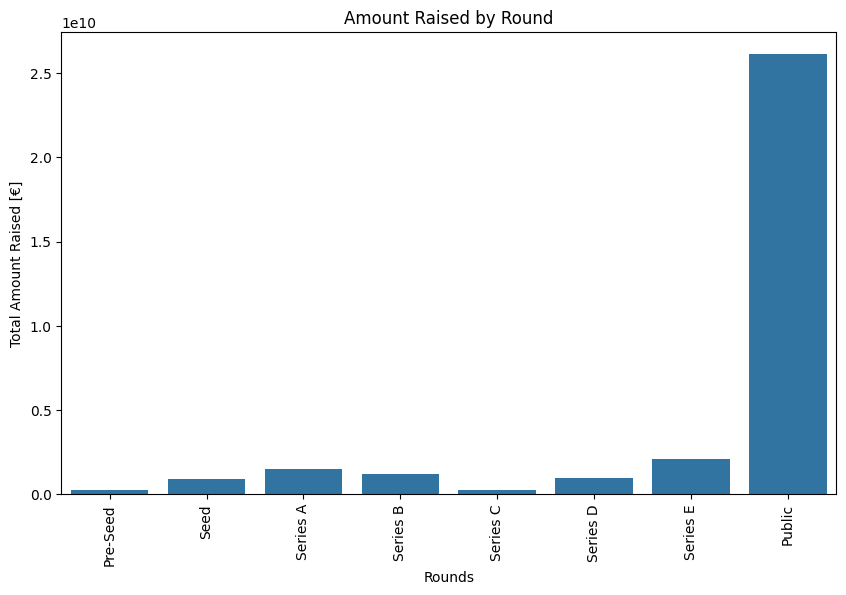

In [92]:
# Define the order of rounds
round_order = ['Pre-Seed', 'Seed', 'Series A', 'Series B', 'Series C', 'Series D', 'Series E', 'Public']

# Group the data by 'Round' and calculate the sum of 'AmountRaised' for each round
round_summary = df.groupby('Round')['AmountRaised_EUR'].sum().reset_index()

# Create the bar chart with the specified order
plt.figure(figsize=(10, 6))
sns.barplot(x='Round', y='AmountRaised_EUR', data=round_summary, order=round_order)
plt.xlabel('Rounds')
plt.ylabel('Total Amount Raised [€]')
plt.title('Amount Raised by Round')
plt.xticks(rotation=90)  # Rotate x-axis labels for readability

# Display the bar chart
plt.show()

pre-seed was in billions which may indicate that some startups are mislabeled. Facebook originally was labelled as Early Stage, Sequoia as Late Stage which we infered as pre-seed and Series E, this is wrong and was corrected. facebook was deemed Pre-Seed because it was origianally labelled Early Stage with amount raised as $13.8B. However Facebook started in 2004 and SEC filing for when facebook was public states that it nearly sold for that amount in 2014. The pre-seed label and amount raised was wrong. sequoia pitch deck was only a template and had two slides at end that were advertising a blog article but were missing images. These missing images caused corruption so were removed.

In [93]:
rows_between_scores = df[(df['AmountRaised_EUR'] <= 15e10) & (df['AmountRaised_EUR'] >= 0.2e10)]
print(len(rows_between_scores))
rows_between_scores.head(20)

3


,Name,Description,Industry,Sector,Business Model,Customer,Round,AmountRaised_EUR,Investor,Year,Links,Location,City,State,Country,Geo
18,Facebook,Facebook is a social network that connects you...,"Social Media, IT",Technology and Software,Marketplace,B2B2C,Public,1.462800e+10,"VC, Corporate",2004,"['http://www.facebook.com/', 'https://www.crun...","['Menlo Park', 'California', 'United States']",Menlo Park,California,United States,"(37.4519671, -122.177992)"
42,Sequoia,Sequoia is a venture capital firm that focuses...,"Venture Capital, IT",Entertainment and Social Media,Marketplace,B2B,Public,7.208000e+09,VC,2018,"['www.sequoiacap.com', 'https://www.crunchbase...","['Menlo Park', 'California', 'United States']",Menlo Park,California,United States,"(37.4519671, -122.177992)"
375,Matterport,"Matterport is well-known for creating a ""digit...","Software, 3D, AR, VR, Digital Twin, Real Estat...",Technology and Software,SaaS,B2B,Public,3.074000e+09,SPAC,2021,"['https://matterport.com', 'https://www.crunch...","['Sunnyvale', 'California', 'United States']",Sunnyvale,California,United States,"(37.3688301, -122.036349)"


In [94]:
df_p = df.loc[df['Round'] == 'Public']
print(len(df_p))
df_p.head(11)

11


,Name,Description,Industry,Sector,Business Model,Customer,Round,AmountRaised_EUR,Investor,Year,Links,Location,City,State,Country,Geo
18,Facebook,Facebook is a social network that connects you...,"Social Media, IT",Technology and Software,Marketplace,B2B2C,Public,1.462800e+10,"VC, Corporate",2004,"['http://www.facebook.com/', 'https://www.crun...","['Menlo Park', 'California', 'United States']",Menlo Park,California,United States,"(37.4519671, -122.177992)"
42,Sequoia,Sequoia is a venture capital firm that focuses...,"Venture Capital, IT",Entertainment and Social Media,Marketplace,B2B,Public,7.208000e+09,VC,2018,"['www.sequoiacap.com', 'https://www.crunchbase...","['Menlo Park', 'California', 'United States']",Menlo Park,California,United States,"(37.4519671, -122.177992)"
326,Yuga Labs,Yuga Labs createdÂ the Bored Ape Yacht Club co...,Crypto,Retail and Consumer,Other,B2C,Public,4.770000e+08,VC,2022,"['https://www.yugalabs.io', 'https://www.crunc...","['Miami', 'Florida', 'United States']",Miami,Florida,United States,"(25.7741728, -80.19362)"
336,Long Journey,"Long Journey Ventures,Â is a San Francisco-bas...","Venture Capital, Tech, Software, Hardware, Con...",Technology and Software,"Venture Capital, Tech, Software, Hardware, Con...","Venture Capital, Tech, Software, Hardware, Con...",Public,3.710000e+07,"VC, Angel Investors",2019,"['https://www.longjourney.vc', 'https://www.cr...","['San Francisco', 'California', 'United States']",San Francisco,California,United States,"(37.7790262, -122.419906)"
375,Matterport,"Matterport is well-known for creating a ""digit...","Software, 3D, AR, VR, Digital Twin, Real Estat...",Technology and Software,SaaS,B2B,Public,3.074000e+09,SPAC,2021,"['https://matterport.com', 'https://www.crunch...","['Sunnyvale', 'California', 'United States']",Sunnyvale,California,United States,"(37.3688301, -122.036349)"
377,Contrarian Ventures,Contrarian VenturesÂ awards grants ranging fro...,"Venture Capital, Sustainability, Climate Tech,...",Technology and Software,VC,VC,Public,8.686000e+07,"VC, Angel Investors",2022,"['https://www.cventures.vc/', 'https://www.cru...","['Vilnius', 'Vilniaus Apskritis', 'Lithuania']",Vilnius,Vilniaus Apskritis,Lithuania,"(54.6870458, 25.2829111)"
384,Leafly,Leafly is a leading online cannabis destinatio...,"Cannabis, Marketplace, Dispensary, Geolocation...",Entertainment and Social Media,SaaS,B2B,Public,1.717200e+08,SPAC,2021,"['https://leafly.com', 'https://www.crunchbase...","['Seattle', 'Washington', 'United States']",Seattle,Washington,United States,"(47.6038321, -122.330062)"
393,Teladoc,Teladoc Health provides a platform for all spe...,"Healthcare, SaaS",Entertainment and Social Media,SaaS,B2B,Public,1.664200e+08,Corporate,2022,"['https://teladoc.com', 'https://www.crunchbas...","['Purchase', 'New York', 'United States']",Purchase,New York,United States,"(41.0409305, -73.7145746)"
395,Susa Ventures,Susa Ventures is a seed-stage venture capital ...,"Venture Capital, Enterprise, Software, FinTech...",Technology and Software,VC,VC,Public,2.120000e+08,"VC, Angel Investors",2021,"['https://susaventures.com', 'https://www.crun...","['San Francisco', 'California', 'United States']",San Francisco,California,United States,"(37.7790262, -122.419906)"
433,GRUBBRR,GRUBBRR is a restaurant management platform th...,"Software, Food & Beverage, Hospitality, Restau...",Entertainment and Social Media,SaaS,B2B,Public,3.710000e+07,"VC, Angel Investors",2022,"['https://grubbrr.com', 'https://www.crunchbas...","['Boca Raton', 'Florida', 'United States']",Boca Raton,Florida,United States,"(26.3586885, -80.0830984)"


In [95]:
new_column_order = [
    'Name', 'Description', 'Industry', 'Sector', 'Business Model',
    'Customer', 'Round', 'Investor', 'Year', 'Links',
    'Location', 'City', 'State', 'Country', 'Geo', 'AmountRaised_EUR'
]
df = df[new_column_order]
df.head()

,Name,Description,Industry,Sector,Business Model,Customer,Round,Investor,Year,Links,Location,City,State,Country,Geo,AmountRaised_EUR
0,Airbnb,Airbnb is an online marketplace for people to ...,"Hospitality, Travel",Retail and Consumer,Marketplace,"B2C, B2B",Seed,"VC, Angel Investors",2008,"['https://airbnb.com/', 'https://www.crunchbas...","['San Francisco', 'California', 'United States']",San Francisco,California,United States,"(37.7790262, -122.419906)",636000.0
1,Alan,Alan is a platform that uses technology to mak...,"FinTech, Healthcare, InsurTech",Healthcare and Biotechnology,App,B2B,Series C,VC,2020,"['https://alan.com/', 'https://www.crunchbase....","['Paris', 'Ile-de-France', 'France']",Paris,Ile-de-France,France,"(48.8534951, 2.3483915)",57240000.0
2,Apptopia,Apptopia serves the mobile industry with an ar...,"Analytics, Big Data, Marketing",Data and Analytics,Subscription,B2B,Series A,VC,2018,"['http://www.apptopia.com/', 'https://www.crun...","['Boston', 'Massachusetts', 'United States']",Boston,Massachusetts,United States,"(42.3554334, -71.060511)",1547600.0
3,Beatdapp,Beatdapp provides real-time tracking of media ...,"Blockchain, Software, Music, Audio, Analytics",Technology and Software,SaaS,B2B,Seed,VC,2019,"['https://beatdapp.com/', 'https://www.crunchb...","['Vancouver', 'British Columbia', 'Canada']",Vancouver,British Columbia,Canada,"(49.2608724, -123.113952)",2544000.0
4,Bind,"Bind provides personalized, cost-transparent a...","InsurTech, Healthcare, HR",Entertainment and Social Media,Subscription,"B2C, B2B",Series A,VC,2018,"['https://www.yourbind.com/', 'https://www.cru...","['Minneapolis', 'Minnesota', 'United States']",Minneapolis,Minnesota,United States,"(44.9772995, -93.2654692)",63600000.0


In [96]:
# Save the updated DataFrame to a new CSV file or overwrite the original one
df.to_csv('data/falory_clean.csv', index=False)

In [97]:
df = pd.read_csv('data/falory_clean.csv')
print(len(df))
df.head(10)

497


,Name,Description,Industry,Sector,Business Model,Customer,Round,Investor,Year,Links,Location,City,State,Country,Geo,AmountRaised_EUR
0,Airbnb,Airbnb is an online marketplace for people to ...,"Hospitality, Travel",Retail and Consumer,Marketplace,"B2C, B2B",Seed,"VC, Angel Investors",2008,"['https://airbnb.com/', 'https://www.crunchbas...","['San Francisco', 'California', 'United States']",San Francisco,California,United States,"(37.7790262, -122.419906)",636000.0
1,Alan,Alan is a platform that uses technology to mak...,"FinTech, Healthcare, InsurTech",Healthcare and Biotechnology,App,B2B,Series C,VC,2020,"['https://alan.com/', 'https://www.crunchbase....","['Paris', 'Ile-de-France', 'France']",Paris,Ile-de-France,France,"(48.8534951, 2.3483915)",57240000.0
2,Apptopia,Apptopia serves the mobile industry with an ar...,"Analytics, Big Data, Marketing",Data and Analytics,Subscription,B2B,Series A,VC,2018,"['http://www.apptopia.com/', 'https://www.crun...","['Boston', 'Massachusetts', 'United States']",Boston,Massachusetts,United States,"(42.3554334, -71.060511)",1547600.0
3,Beatdapp,Beatdapp provides real-time tracking of media ...,"Blockchain, Software, Music, Audio, Analytics",Technology and Software,SaaS,B2B,Seed,VC,2019,"['https://beatdapp.com/', 'https://www.crunchb...","['Vancouver', 'British Columbia', 'Canada']",Vancouver,British Columbia,Canada,"(49.2608724, -123.113952)",2544000.0
4,Bind,"Bind provides personalized, cost-transparent a...","InsurTech, Healthcare, HR",Entertainment and Social Media,Subscription,"B2C, B2B",Series A,VC,2018,"['https://www.yourbind.com/', 'https://www.cru...","['Minneapolis', 'Minnesota', 'United States']",Minneapolis,Minnesota,United States,"(44.9772995, -93.2654692)",63600000.0
5,BlaBlaCar,BlaBlaCar is a long distance ride-sharing plat...,"Ride Sharing, CleanTech, Collaboration, Transp...",Retail and Consumer,Marketplace,C2C,Series E,"Corporate, VC",2016,"['www.blablacar.com', 'https://www.crunchbase....","['Paris', 'Ile-de-France', 'France']",Paris,Ile-de-France,France,"(48.8534951, 2.3483915)",21000000.0
6,Blue Wire,Blue Wire is a network of podcasters who cover...,"Audio, Media, Entertainment, Sports",Retail and Consumer,Other,B2C,Pre-Seed,VC,2020,"['https://bluewirepods.com/', 'https://www.cru...","['San Francisco', 'California', 'United States']",San Francisco,California,United States,"(37.7790262, -122.419906)",1272000.0
7,Blue Apron,Blue Apron is a leading online marketplace for...,"Food, Logistics",Financial Services,Subscription,B2C,Series D,Corporate,2015,"['https://www.blueapron.com/', 'https://www.cr...","['New York', 'New York', 'United States']",New York,New York,United States,"(40.7127281, -74.0060152)",143100000.0
8,Brex,Brex is an all-in-one business finance solutio...,"FinTech, Accounting, Payments",Healthcare and Biotechnology,SaaS,B2B,Series B,"VC, Corporate, Accelerator",2018,"['https://www.brex.com/', 'https://www.crunchb...","['San Francisco', 'California', 'United States']",San Francisco,California,United States,"(37.7790262, -122.419906)",60420000.0
9,Buffer,Bufferâs suite of apps and tools are designe...,"Marketing, Social Media, Analytics, Productivity",Data and Analytics,"SaaS, Subscription",B2B,Seed,"VC, Angel Investors",2011,"['https://buffer.com/', 'https://www.crunchbas...","['San Francisco', 'California', 'United States']",San Francisco,California,United States,"(37.7790262, -122.419906)",530000.0


In [99]:
df_y = df.loc[df['Year'] == 'Undisclosed']
print(len(df_y))
df_y.head()

1


,Name,Description,Industry,Sector,Business Model,Customer,Round,Investor,Year,Links,Location,City,State,Country,Geo,AmountRaised_EUR
495,PIllar,Pillar to post provides structural and foundat...,FinTech,Healthcare and Biotechnology,FinTech,FinTech,Seed,"VC, Angel Investors",Undisclosed,"['https://pillartopost.com', 'https://www.crun...","['Tampa', 'Florida', 'United States']",Tampa,Florida,United States,"(27.9477595, -82.458444)",5830000.0


In [101]:
df.loc[df['Name'] == 'PIllar', 'Year'] = 1994
df_y = df.loc[df['Year'] == 'Undisclosed']
print(len(df_y))
df_y.head()

0


,Name,Description,Industry,Sector,Business Model,Customer,Round,Investor,Year,Links,Location,City,State,Country,Geo,AmountRaised_EUR


In [102]:
# Save the updated DataFrame to a new CSV file or overwrite the original one
df.to_csv('data/falory_clean.csv', index=False)

In [105]:
# Manually fixed Geo location NONE
df = pd.read_csv('data/falory_clean.csv')

In [106]:
df.head()

,Name,Description,Industry,Sector,Business Model,Customer,Round,Investor,Year,Links,Location,City,State,Country,Geo,AmountRaised_EUR
0,Airbnb,Airbnb is an online marketplace for people to ...,"Hospitality, Travel",Retail and Consumer,Marketplace,"B2C, B2B",Seed,"VC, Angel Investors",2008,"['https://airbnb.com/', 'https://www.crunchbas...","['San Francisco', 'California', 'United States']",San Francisco,California,United States,"(37.7790262, -122.419906)",636000
1,Alan,Alan is a platform that uses technology to mak...,"FinTech, Healthcare, InsurTech",Healthcare and Biotechnology,App,B2B,Series C,VC,2020,"['https://alan.com/', 'https://www.crunchbase....","['Paris', 'Ile-de-France', 'France']",Paris,Ile-de-France,France,"(48.8534951, 2.3483915)",57240000
2,Apptopia,Apptopia serves the mobile industry with an ar...,"Analytics, Big Data, Marketing",Data and Analytics,Subscription,B2B,Series A,VC,2018,"['http://www.apptopia.com/', 'https://www.crun...","['Boston', 'Massachusetts', 'United States']",Boston,Massachusetts,United States,"(42.3554334, -71.060511)",1547600
3,Beatdapp,Beatdapp provides real-time tracking of media ...,"Blockchain, Software, Music, Audio, Analytics",Technology and Software,SaaS,B2B,Seed,VC,2019,"['https://beatdapp.com/', 'https://www.crunchb...","['Vancouver', 'British Columbia', 'Canada']",Vancouver,British Columbia,Canada,"(49.2608724, -123.113952)",2544000
4,Bind,"Bind provides personalized, cost-transparent a...","InsurTech, Healthcare, HR",Entertainment and Social Media,Subscription,"B2C, B2B",Series A,VC,2018,"['https://www.yourbind.com/', 'https://www.cru...","['Minneapolis', 'Minnesota', 'United States']",Minneapolis,Minnesota,United States,"(44.9772995, -93.2654692)",63600000


In [108]:
df = df.drop('Location', axis=1)

In [109]:
df.head()

,Name,Description,Industry,Sector,Business Model,Customer,Round,Investor,Year,Links,City,State,Country,Geo,AmountRaised_EUR
0,Airbnb,Airbnb is an online marketplace for people to ...,"Hospitality, Travel",Retail and Consumer,Marketplace,"B2C, B2B",Seed,"VC, Angel Investors",2008,"['https://airbnb.com/', 'https://www.crunchbas...",San Francisco,California,United States,"(37.7790262, -122.419906)",636000
1,Alan,Alan is a platform that uses technology to mak...,"FinTech, Healthcare, InsurTech",Healthcare and Biotechnology,App,B2B,Series C,VC,2020,"['https://alan.com/', 'https://www.crunchbase....",Paris,Ile-de-France,France,"(48.8534951, 2.3483915)",57240000
2,Apptopia,Apptopia serves the mobile industry with an ar...,"Analytics, Big Data, Marketing",Data and Analytics,Subscription,B2B,Series A,VC,2018,"['http://www.apptopia.com/', 'https://www.crun...",Boston,Massachusetts,United States,"(42.3554334, -71.060511)",1547600
3,Beatdapp,Beatdapp provides real-time tracking of media ...,"Blockchain, Software, Music, Audio, Analytics",Technology and Software,SaaS,B2B,Seed,VC,2019,"['https://beatdapp.com/', 'https://www.crunchb...",Vancouver,British Columbia,Canada,"(49.2608724, -123.113952)",2544000
4,Bind,"Bind provides personalized, cost-transparent a...","InsurTech, Healthcare, HR",Entertainment and Social Media,Subscription,"B2C, B2B",Series A,VC,2018,"['https://www.yourbind.com/', 'https://www.cru...",Minneapolis,Minnesota,United States,"(44.9772995, -93.2654692)",63600000


In [110]:
# Get the list of column names
columns = df.columns.tolist()

# Remove 'Links' from the list of columns
columns.remove('Links')

# Insert 'Links' at the second last position
columns.insert(-1, 'Links')

# Reorder the DataFrame's columns
df = df[columns]
df.head()

,Name,Description,Industry,Sector,Business Model,Customer,Round,Investor,Year,City,State,Country,Geo,Links,AmountRaised_EUR
0,Airbnb,Airbnb is an online marketplace for people to ...,"Hospitality, Travel",Retail and Consumer,Marketplace,"B2C, B2B",Seed,"VC, Angel Investors",2008,San Francisco,California,United States,"(37.7790262, -122.419906)","['https://airbnb.com/', 'https://www.crunchbas...",636000
1,Alan,Alan is a platform that uses technology to mak...,"FinTech, Healthcare, InsurTech",Healthcare and Biotechnology,App,B2B,Series C,VC,2020,Paris,Ile-de-France,France,"(48.8534951, 2.3483915)","['https://alan.com/', 'https://www.crunchbase....",57240000
2,Apptopia,Apptopia serves the mobile industry with an ar...,"Analytics, Big Data, Marketing",Data and Analytics,Subscription,B2B,Series A,VC,2018,Boston,Massachusetts,United States,"(42.3554334, -71.060511)","['http://www.apptopia.com/', 'https://www.crun...",1547600
3,Beatdapp,Beatdapp provides real-time tracking of media ...,"Blockchain, Software, Music, Audio, Analytics",Technology and Software,SaaS,B2B,Seed,VC,2019,Vancouver,British Columbia,Canada,"(49.2608724, -123.113952)","['https://beatdapp.com/', 'https://www.crunchb...",2544000
4,Bind,"Bind provides personalized, cost-transparent a...","InsurTech, Healthcare, HR",Entertainment and Social Media,Subscription,"B2C, B2B",Series A,VC,2018,Minneapolis,Minnesota,United States,"(44.9772995, -93.2654692)","['https://www.yourbind.com/', 'https://www.cru...",63600000


In [111]:
# Save the updated DataFrame to a new CSV file or overwrite the original one
df.to_csv('data/falory_clean.csv', index=False)